# Introduction

This analysis seeks to bring understanding to data regarding police interactions known as Terry stops. According to [Merriam-Webster](https://www.merriam-webster.com/legal/Terry%20stop), a Terry stop is "a stop and limited search of a person for weapons justified by a police officer's reasonable conclusion that a crime is being or about to be committed by a person who may be armed and whose responses to questioning do not dispel the officer's fear of danger to the officer or to others." 

## Data Sources

The city of Seattle [provides](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8) substantial publicly available data about these encounters. There are over 47,000 records spanning a period from 2015 to 2021. It includes 23 different features, including topics such as race, gender, age, location, call type, and the final resolution of the stop -- whether it ended in arrest or citation, for example.

## The Process
This analysis will follow the general structure listed here:
1. Setup and Data Import
2. Data Cleaning
3. Feature Engineering
4. Graphical Exploratory Data Analysis (EDA)
5. Feature Selection
6. Modeling
7. Results Interpretation
8. Conclusion

### Additional Notes
This notebook provides a somewhat condensed analysis compared to the full sequence necessary to understand the all details of choosing specific models and the nitty-gritty details of feature selection. Please refer to the EDA notebook in this folder for that analysis.

## Part I: Setup and Data Import
**Import relevant packages**

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os, sys
from datetime import time

# Data manipulation packages
from custom_functions import *
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Modeling packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import KFold, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model evaluation packages
import shap
from sklearn.metrics import f1_score, plot_confusion_matrix

# Basic settings for an easier to use notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)

**Declare static variables used throughout notebook**

In [2]:
# Global static variable declarations used throughout notebook
RANDOM_STATE = 0
raw_terry_path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
processed_data_path = os.path.join('..', 'data', 'processed')
UNKNOWN = 'Not provided'
N_SPLITS = 3
JOBS = 2

**Import full dataset from *data* folder**

In [3]:
df = pd.read_csv(raw_terry_path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

# Part II: Data Cleaning
**Dictionaries are used to categorize, reclassify, and correct typographical errors for each column as relevant.**

In [4]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------

# Subject Age Group
df['Subject Age Group'].replace('-', np.nan, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', UNKNOWN, inplace=True)


# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')


# Officer Race
race_dict = {'Unknown': UNKNOWN, 
            'Not Specified': UNKNOWN,
            '-': UNKNOWN,
            'Other': UNKNOWN, 
            'Unknown': UNKNOWN}
df['Officer Race'].replace(race_dict, inplace=True)
df['Subject Perceived Race'].replace(race_dict, inplace=True)


# Gender
gender_dict = {'Unable to Determine': UNKNOWN,
              '-': UNKNOWN,
               'Unknown': UNKNOWN,
              'Gender Diverse (gender non-conforming and/or transgender)': 'Non-Binary',
               'N': 'Non-Binary',
               'M': 'Male',
               'F': 'Female'}
df['Subject Perceived Gender'].replace(gender_dict, inplace=True)
df['Officer Gender'].replace(gender_dict, inplace=True)


# Race - grouped for naming consistency and aggregating small sample sizes for statistical significance
race_dict = {'Two or More Races': 'Multi-Racial',
            'Hispanic or Latino': 'Hispanic',
            'Nat Hawaiian/Oth Pac Islander': 'Native', 
            'American Indian/Alaska Native': 'Native',
            'Native Hawaiian or Other Pacific Islander': 'Native',
            'American Indian or Alaska Native': 'Native'}
df['Subject Perceived Race'].replace(race_dict, inplace=True)
df['Officer Race'].replace(race_dict, inplace=True)


# Reported date and hour
df['Reported Date'] = df['Reported Date'].astype('datetime64')
    
    
# Call Type
call_type_dict = {'-': UNKNOWN,
                 'SCHEDULED EVENT (RECURRING)': UNKNOWN,
                 'TEXT MESSAGE': UNKNOWN,
                 'TELEPHONE OTHER, NOT 911': UNKNOWN,
                 'ONVIEW': 'Onview', 
                 'ALARM CALL (NOT POLICE ALARM)': 'Alarm'}
df['Call Type'].replace(call_type_dict, inplace=True)
    
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)


# Precinct
precinct_dict = {'-': UNKNOWN,
                'FK ERROR': UNKNOWN,
                 'Unknown': UNKNOWN,
                'SouthWest': 'Southwest'}
df['Precinct'].replace(precinct_dict, inplace=True)


# Sector
df['Sector'].replace(['99', '-'], UNKNOWN, inplace=True)


# Subject age group
df['Subject Age Group'].replace('-', np.nan, inplace=True)


# Required for downstream one-hot encoding
df['Officer Squad'].fillna(UNKNOWN, inplace=True)


# Change 'Y' and 'N' to binary 1/0
df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
df.drop('Arrest Flag', axis=1, inplace=True)
    
# Change 'Y' and 'N' to binary 1/0
df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
df.drop('Frisk Flag', axis=1, inplace=True)


# Difficult decision to make, but with a sample size of only 5 people, the 
# amount of data is insufficient to provide a statistically significant understanding
# of how non-binary appearance affects arrest rate
df['Subject Perceived Gender'].replace('Non-Binary', UNKNOWN, inplace=True)
df['Officer Gender'].replace('Non-Binary', UNKNOWN, inplace=True)


# Weapon Type
weapon_type_dict = {'Firearm Other': 'Firearm', 
                    'Lethal Cutting Instrument': 'Knife', 
                    'Handgun': 'Firearm', 
                    '-': 'None', 
                    'Club, Blackjack, Brass Knuckles': UNKNOWN, 
                    'Knife/Cutting/Stabbing Instrument': 'Knife', 
                    'Other Firearm': 'Firearm', 
                    'Rifle': 'Firearm', 
                    'Fire/Incendiary Device': UNKNOWN, 
                    'Blunt Object/Striking Implement': UNKNOWN, 
                    'Firearm (unk type)': 'Firearm', 
                    'Mace/Pepper Spray': UNKNOWN, 
                    'None/Not Applicable': 'None', 
                    'Club': UNKNOWN, 
                    'Taser/Stun Gun': UNKNOWN, 
                    'Shotgun': 'Firearm', 
                    'Brass Knuckles': UNKNOWN, 
                    'Automatic Handgun': 'Firearm', 
                    'Blackjack': UNKNOWN, 
                    'Personal Weapons (hands, feet, etc.)': UNKNOWN}
df['Weapon Type'].replace(weapon_type_dict, inplace=True)



# Remove missing values
df.dropna(inplace=True)

**Display info about the remaining data**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45664 entries, 214 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Subject Age Group         45664 non-null  object        
 1   Subject ID                45664 non-null  object        
 2   GO / SC Num               45664 non-null  object        
 3   Terry Stop ID             45664 non-null  object        
 4   Stop Resolution           45664 non-null  object        
 5   Weapon Type               45664 non-null  object        
 6   Officer ID                45664 non-null  object        
 7   Officer YOB               45664 non-null  int32         
 8   Officer Gender            45664 non-null  object        
 9   Officer Race              45664 non-null  object        
 10  Subject Perceived Race    45664 non-null  object        
 11  Subject Perceived Gender  45664 non-null  object        
 12  Reported Date   

# Part III: Feature Engineering
**See EDA notebook for more details on feature engineering. Below are the final selected choices.**

**Calculate officer age based on their year of birth and the year the Terry stop occurred.**

In [6]:
df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']

# Fill missing values with median
# Note there are some outliers with unrealistically high ages. Replace w/median.
median_age = df.loc[df['Officer Age']<100, 'Officer Age'].median()
df['Officer Age'] = df['Officer Age'].apply(lambda x: median_age if x > 100 else x).astype('int')
df.drop('Officer YOB', axis=1, inplace=True)

**Create binary metric indicating whether the subject had a weapon.**

In [7]:
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')

**Identify whether the officer is of the same race and same gender as the subject.**

In [8]:
#Race
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race']).astype('int')

# Gender
df['Same Gender (Y/N)'] = (df['Officer Gender'] == df['Subject Perceived Gender']).astype('int')

**Identify repeat offenders**

In [9]:
# Calculate the number of stops per subject
offense_ct_dict = dict(df['Subject ID'].value_counts())
df['Offense Count'] = df['Subject ID'].map(offense_ct_dict)

# Identify whether a subject has been involved in multiple stops
df['Repeat Offender (Y/N)'] = (df['Offense Count'] > 1).astype('int')

# Drop "Offense Count" given the number of missing values
df.drop('Offense Count', axis=1, inplace=True)
df.drop('Subject ID', axis=1, inplace=True)


**Estimate subject age based on the categorical age buckets and the statistical distribution of ages within the dataset.** 

Note that these estimates are never outside of the age "buckets" provided in the original dataset so no data integrity is lost. Instead, granularity is added that does, in aggregate, bring increased accuracy to the feature. The red dots represent a histogram of each age bucket in the original dataset. For example, there are roughly 600 records categorized in the 45-55 years old bucket. The blue lines represent a histogram of the estimated ages in the final dataset. They are sampled from a distribution of the overall age buckets. In the EDA section, it was determined that this methodology provides a small degree of increased model accuracy over the alternative of age bracket categories. 

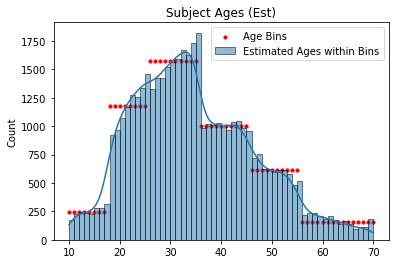

In [10]:
from estimate_ages import estimate_age_from_categorical
df['Subject Age (Est)'] = estimate_age_from_categorical(df, UNKNOWN)

# Remove the categorical feature after estimating the continuous feature based on its values
df.drop('Subject Age Group', axis=1, inplace=True)

**Categorize "Stop Resolution" to create an appropriate target metric.**

The most appropriate target was determined to be one that will have a lasting impact on the subject's criminal record. Refer to the below dictionary to see how those are classified. 

**Going forward, a "negative outcome" refers to a resolution that will persist on the subject's criminal record following the interaction.**

In [11]:
dict_resolution = {
    'Field Contact': 'Neutral',
    'Offense Report': 'Negative',
    'Arrest': 'Negative',
    'Referred for Prosecution': 'Negative',
    'Citation / Infraction': 'Negative'}

df['Resolution: Negative (Y/N)'] = (df['Stop Resolution'].map(dict_resolution) == 'Negative')
df['Resolution: Negative (Y/N)'] = (df['Resolution: Negative (Y/N)']).astype('int')

# Remove original pre-categorization feature
df.drop('Stop Resolution', axis=1, inplace=True)

In [12]:
# Remove missing values and reset index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# Part IV: Graphical EDA

Explore the relationships between selected features.

**First, investigate the relationship between age and a negative outcome.**

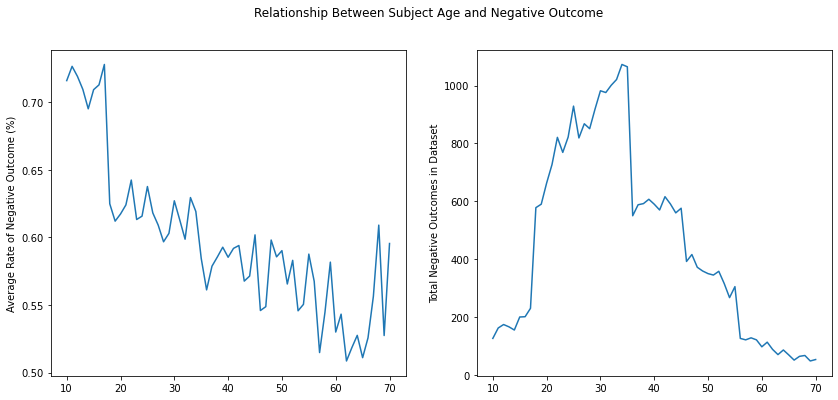

In [13]:
# Create data to plot
min_age = df['Subject Age (Est)'].min()
max_age = df['Subject Age (Est)'].max()
ages = list(range(min_age, max_age+1))
negative_outcome_ct = []
negative_outcome_rate = []

for age in ages:
    grouped = df.loc[df['Subject Age (Est)'] == age]
    target = grouped['Resolution: Negative (Y/N)']
    negative_outcome_ct.append(target.sum())
    negative_outcome_rate.append(target.mean())

    
# Create plot
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 6))
plt.suptitle('Relationship Between Subject Age and Negative Outcome')

axes[0].plot(ages, negative_outcome_rate)
axes[0].set_ylabel('Average Rate of Negative Outcome (%)')

axes[1].plot(ages, negative_outcome_ct)
axes[1].set_ylabel('Total Negative Outcomes in Dataset');

**Investigate the relationship between Officer Age and a negative outcome**

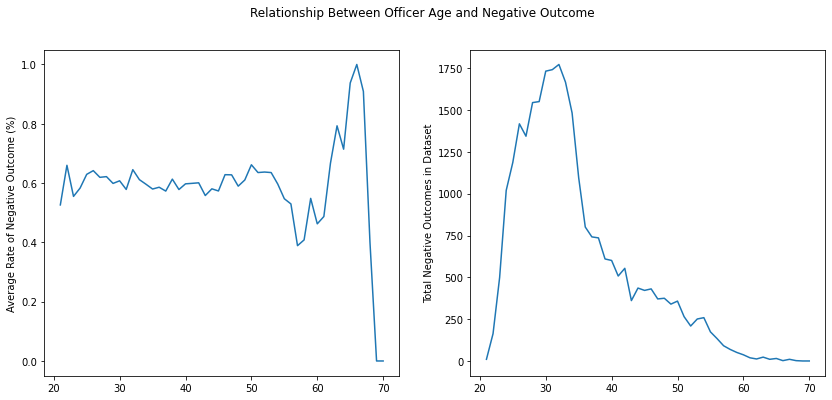

In [14]:
# Create data to plot
min_age = df['Officer Age'].min()
max_age = df['Officer Age'].max()
ages = list(range(min_age, max_age+1))
negative_outcome_ct = []
negative_outcome_rate = []

for age in ages:
    grouped = df.loc[df['Officer Age'] == age]
    target = grouped['Resolution: Negative (Y/N)']
    negative_outcome_ct.append(target.sum())
    negative_outcome_rate.append(target.mean())

    
# Create plot
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 6))
plt.suptitle('Relationship Between Officer Age and Negative Outcome')

axes[0].plot(ages, negative_outcome_rate)
axes[0].set_ylabel('Average Rate of Negative Outcome (%)')

axes[1].plot(ages, negative_outcome_ct)
axes[1].set_ylabel('Total Negative Outcomes in Dataset');

**Investigate the relationship between subject race and a negative outcome**

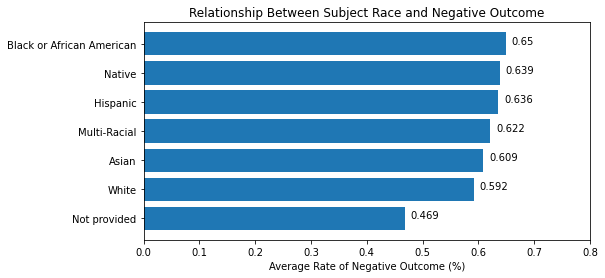

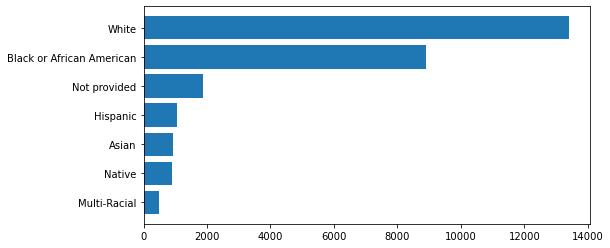

In [15]:
# Create data to plot
subject_races = df['Subject Perceived Race'].unique()
negative_outcome_ct = []
negative_outcome_rate = []

for race in subject_races:
    grouped = df.loc[df['Subject Perceived Race'] == race]
    target = grouped['Resolution: Negative (Y/N)']
    negative_outcome_ct.append(target.sum())
    negative_outcome_rate.append(target.mean())

# Sort results in descending order
zipped = zip(subject_races, negative_outcome_rate)
zipped_sorted = sorted(zipped, key = lambda x: x[1], reverse=False)

# Extract from tuples
races = [x[0] for x in zipped_sorted]
rates = [x[1] for x in zipped_sorted]


# Create plot - AVERAGE RATE OF NEGATIVE OUTCOME
plt.figure(figsize=(8, 4))
plt.title('Relationship Between Subject Race and Negative Outcome')
plt.barh(races, rates)
plt.xlabel('Average Rate of Negative Outcome (%)');
plt.xlim(0,0.8)


for index,data in enumerate(rates):
    plt.text(y=index , x =data + 0.01 , s=f"{round(data, 3)}")
    
    

    
    
# Sort results in descending order
zipped = zip(subject_races, negative_outcome_ct)
zipped_sorted = sorted(zipped, key = lambda x: x[1], reverse=False)

# Extract from tuples
races = [x[0] for x in zipped_sorted]
total = [x[1] for x in zipped_sorted]
    
plt.figure(figsize=(8,4))
plt.barh(races, total);

**Investigate other interesting relationships**

<Figure size 432x288 with 0 Axes>

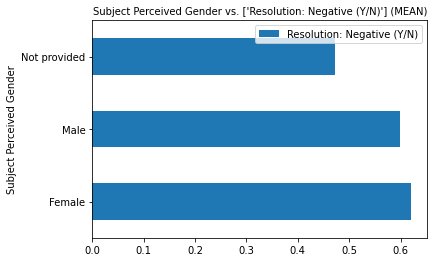

  Subject Perceived Gender  Resolution: Negative (Y/N)
0                   Female                    0.620977
1                     Male                    0.598164
2             Not provided                    0.471831
--------------------------------------------------------------------




<Figure size 432x288 with 0 Axes>

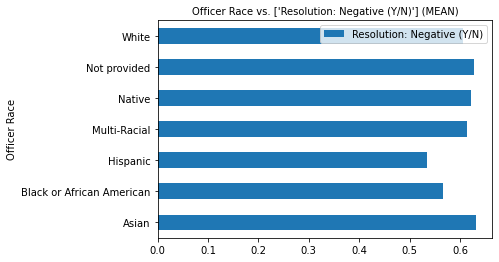

                Officer Race  Resolution: Negative (Y/N)
0                      Asian                    0.632368
5               Not provided                    0.628134
4                     Native                    0.621803
3               Multi-Racial                    0.614579
6                      White                    0.605456
1  Black or African American                    0.565466
2                   Hispanic                    0.533639
--------------------------------------------------------------------




<Figure size 432x288 with 0 Axes>

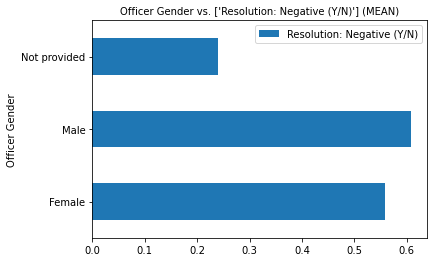

  Officer Gender  Resolution: Negative (Y/N)
1           Male                    0.608529
0         Female                    0.557436
2   Not provided                    0.240000
--------------------------------------------------------------------




In [19]:
# Gender metrics
x_axis = 'Subject Perceived Gender'
y_axis = ['Resolution: Negative (Y/N)']
bar_plot(df, x_axis, y_axis, 'mean', verbose=True)

# Officer race
x_axis = 'Officer Race'
bar_plot(df, x_axis, y_axis, 'mean',verbose=True)

# Officer gender
x_axis = 'Officer Gender'
bar_plot(df, x_axis, y_axis, 'mean', verbose=True)